In [1]:
import scipy.io
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

In [2]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results
from comsolml.vel_estim import FK_thickness_estimation, make_lamb_curves

In [3]:
sns.set_style('whitegrid')
sns.set_context('paper')

In [4]:
timesamples = 400
noisedb = -18
dt = 1e-6
numsensors = 8
circ = 3455*0.2e-3
encoding_dim = 64

In [5]:
def make_dx(decim):
    dx = circ/8*decim
    return dx

def make_dtheta(decim):
    dtheta = 2*np.pi/8*decim
    return dtheta

def conv_m_to_rad(meters, circumference):
    theta = 2*np.pi*meters/circumference
    return theta

In [6]:
make_dtheta(1)

0.7853981633974483

In [7]:
read_data

<module 'comsolml.read_data' from 'c:\\Users\\Magnus\\PycharmProjects\\PhD\\Comsol_ML\\notebooks\\comsolml\\read_data.py'>

# COMSOL Data

In [8]:
filename_synth = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145.mat')
X = read_data.read_synth(filename_synth, 'concat_traces', 9, 18, geom_spread=False)

In [9]:
X.shape

(3341, 8, 401)

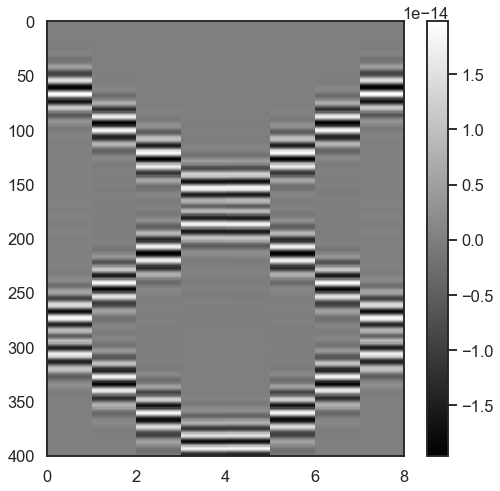

In [10]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [11]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f80_145.csv'))

In [12]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [13]:
'''
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()
'''

"\nsns.set_style('white')\nsns.set_context('talk')\nplt.figure(figsize=(12,8))\nplt.subplot(1,2,1)\nplt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\nplt.subplot(1,2,2)\nplt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\n\n\nplt.show()\n"

# Verasonics Data

In [14]:
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_09', 'data')
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_14', 'data')
pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_09_13', 'data')

In [18]:
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-03_15_15_55.mat')
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-09_15_57_15.mat')

#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_22_20.mat') #strap off
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_26_56.mat') #strap on
#filename_data = Path().joinpath(pathname_data, '080kHz_8ch_s1_2023-03-14_13_30_15.mat')
#filename_data = Path().joinpath(pathname_data, '100kHz_8ch_s1_2023-03-14_13_31_21.mat')
#filename_data = Path().joinpath(pathname_data, '120kHz_8ch_s1_2023-03-14_13_32_29.mat')
#filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-09-13_13_41_51.mat")

#filename_data = Path().joinpath(pathname_data, "078kHz_8ch_s1_2023-09-13_13_41_20.mat")

filename_data = Path().joinpath(pathname_data, "070kHz_8ch_s1_2023-09-13_13_39_07.mat")



In [19]:
mat = scipy.io.loadmat(filename_data)

In [20]:
meta = mat['meta']
t_array = meta['FTaxis'][0,0]
data = mat['RFdata']

In [21]:
data = data[:,1:,:] #Remove source trace

In [22]:
np.diff(t_array).mean()/1e-6

0.8

Sample rate is 0.8 microseconds (1.25Mhz)

In [23]:
native_dt = 0.8e-6

In [24]:
1/native_dt

1250000.0

In [25]:
data_stack = np.sum(data, axis=2)

In [26]:
def remove_dc(data):
    return data - data.mean(axis=0, keepdims=True)

In [27]:
data_stack_dc_removed = remove_dc(data_stack)

In [28]:
def compute_rms(trace):
    squared = np.float64(np.square(trace))
    mean = np.sum(squared)/len(trace)
    rms = np.sqrt(mean)
    return rms

In [29]:
def compute_rms_values(data):
    rms_values = []
    trace_nums = np.arange(0, data.shape[1])
    for trace_num in trace_nums:
        rms_values.append(compute_rms(data[:,trace_num]))
    return rms_values

In [30]:
rms_values = compute_rms_values(data_stack_dc_removed[:,:])

In [31]:
scaling_factors = [1/x for x in rms_values]

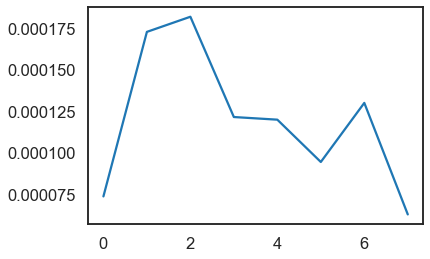

In [32]:
plt.plot(scaling_factors)

In [33]:
data_stack_scaled = np.zeros(shape=data_stack_dc_removed.shape)
for trace_num, scaling_factor in enumerate(scaling_factors):
    data_stack_scaled[:,trace_num] = scaling_factor*data_stack_dc_removed[:,trace_num]

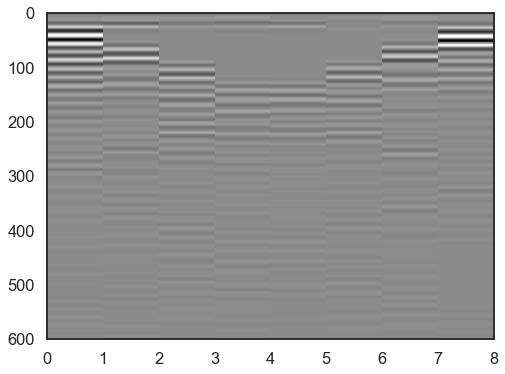

In [34]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled[:600,:], cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [35]:
#data_stack_scaled.shape, X_sample_n.shape

In [36]:
# Crop and Resample
data_stack_scaled_resamp = scipy.signal.resample(data_stack_scaled[:600,:], 480).T

In [37]:
data_stack_scaled_resamp.shape

(8, 480)

In [38]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

In [39]:
data_stack_scaled_resamp.min()

-1.1896296004976414

In [40]:
labels[(labels['Thickness'] == 6.8)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.800000,6.8,0.000000,0.000000,1.000000,0
43,model_s101_t034_d000_p002,6.8,101,0.0,0.4,351.267366,55.653407,6.8,6.4,6.603877,6.6,0.145226,0.021091,1.271427,0
44,model_s101_t034_d000_p004,6.8,101,0.0,0.8,351.267366,55.653407,6.8,6.0,6.469792,6.4,0.234485,0.054983,1.314587,228
45,model_s101_t034_d000_p006,6.8,101,0.0,1.2,351.267366,55.653407,6.8,5.6,6.414352,6.4,0.289402,0.083753,1.322979,85
46,model_s101_t034_d000_p008,6.8,101,0.0,1.6,351.267366,55.653407,6.8,5.2,6.399595,6.4,0.310864,0.096637,1.324897,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,model_s116_t034_d024_p002,6.8,116,4.8,0.4,302.458280,37.896593,6.8,1.6,5.943345,6.6,1.359942,1.849443,1.274064,0
3211,model_s116_t034_d024_p004,6.8,116,4.8,0.8,302.458280,37.896593,6.8,1.2,5.813947,6.4,1.368364,1.872419,1.312067,178
3212,model_s116_t034_d024_p006,6.8,116,4.8,1.2,302.458280,37.896593,6.8,1.0,5.745023,6.2,1.380354,1.905376,1.324056,88
3213,model_s116_t034_d024_p008,6.8,116,4.8,1.6,302.458280,37.896593,6.8,1.0,5.713773,6.2,1.388619,1.928262,1.324535,33


In [41]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [42]:
X.max()

4.4753108e-14

In [43]:
#X_crop = X[:,:,26:]

In [44]:
#time_scaling = np.cbrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

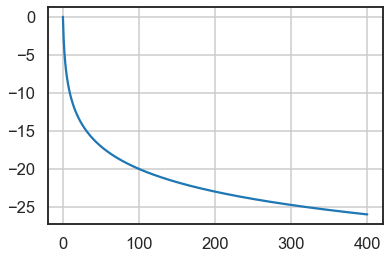

In [45]:
plt.plot(20*np.log10(1/time_scaling[0]))
plt.grid()
plt.show()

In [46]:
X.shape

(3341, 8, 401)

In [47]:
X_geom = np.divide(X, time_scaling**3)

In [48]:
X_sample_c = X_geom/X_geom.max()

In [49]:
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)

In [50]:
X_sample_n.max()

1.0179072305425432

## Low-pass filter

In [51]:
help(scipy.signal.butter)

Help on function butter in module scipy.signal._filter_design:

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
    Butterworth digital and analog filter design.
    
    Design an Nth-order digital or analog Butterworth filter and return
    the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    Wn : array_like
        The critical frequency or frequencies. For lowpass and highpass
        filters, Wn is a scalar; for bandpass and bandstop filters,
        Wn is a length-2 sequence.
    
        For a Butterworth filter, this is the point at which the gain
        drops to 1/sqrt(2) that of the passband (the "-3 dB point").
    
        For digital filters, if `fs` is not specified, `Wn` units are
        normalized from 0 to 1, where 1 is the Nyquist frequency (`Wn` is
        thus in half cycles / sample and defined as 2*critical frequencies
        / `fs`). If `fs` is specified, `Wn` is in the same units as `fs`.


In [52]:
b, a = scipy.signal.butter(4, 85e3, fs=1e6)

C:\Users\Magnus\AppData\Local\Temp\ipykernel_24380\640816349.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(20*np.log10(np.abs(np.fft.rfft(imp_ff))))


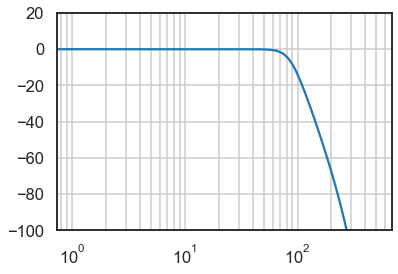

In [53]:
impulse = np.zeros(1000)
impulse[500] = 1
imp_ff = scipy.signal.filtfilt(b, a, impulse)
plt.semilogx(20*np.log10(np.abs(np.fft.rfft(imp_ff))))
plt.grid('True', which='both')
plt.ylim(-100, 20);

In [54]:
sig_ff = scipy.signal.filtfilt(b, a, data_stack_scaled_resamp, axis=1)

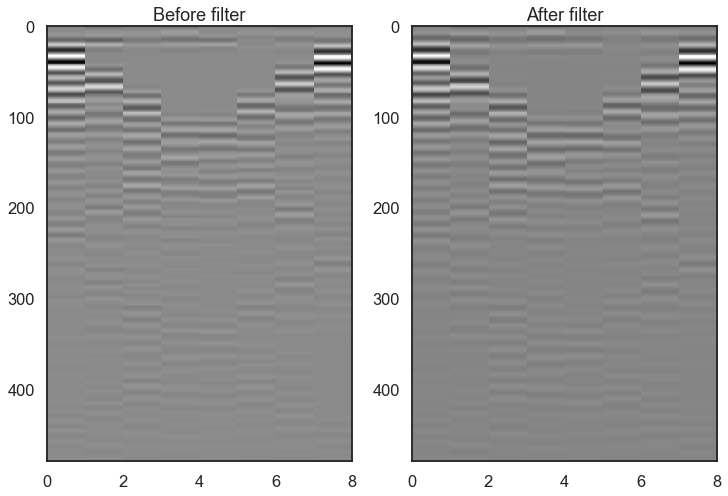

In [55]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp[:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Before filter')
plt.subplot(122)
plt.pcolormesh(sig_ff[:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('After filter');

In [56]:
data_stack_scaled_resamp = sig_ff

In [57]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

In [58]:
data_stack_scaled_resamp_n = data_stack_scaled_resamp + make_noise(noisedb, data_stack_scaled_resamp.shape)

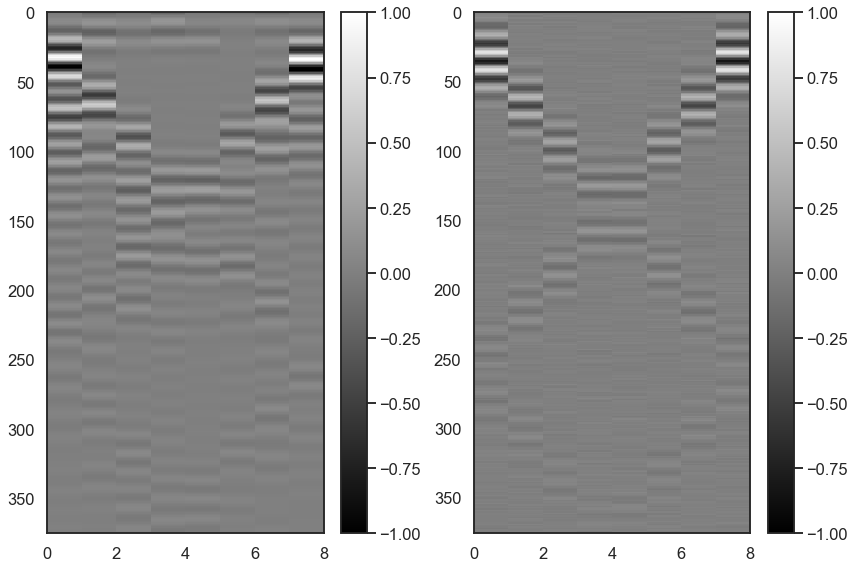

In [59]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp[:,:375].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1, 1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n[42,:,25:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1,1)
plt.colorbar()
plt.tight_layout()

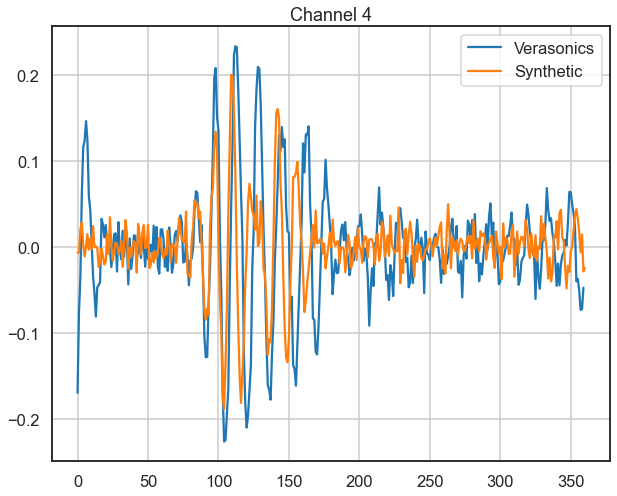

In [60]:
sns.set_context('talk')
plt.figure(figsize=(10,8))
plt.plot(data_stack_scaled_resamp_n[3,15:375], label='Verasonics')
plt.plot(X_sample_n[42,3,40:], label='Synthetic')
plt.legend()
plt.title('Channel 4')
plt.grid()
plt.show()

In [61]:
X_sample_c[:,:,41:].shape
X_sample_c_crop = X_sample_c[:,:,41:]

In [62]:
X_sample_n_crop = X_sample_n[:,:,41:]

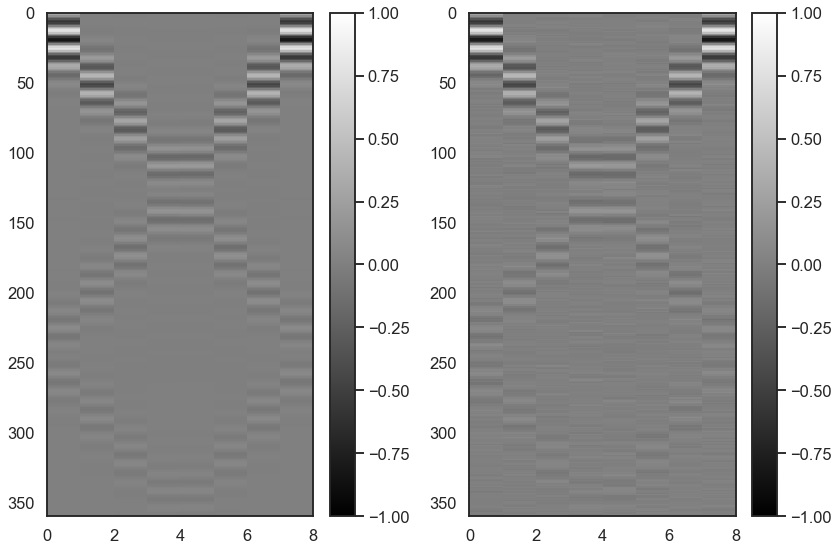

In [63]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(X_sample_c_crop[42,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1, 1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n_crop[42,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1,1)
plt.colorbar()
plt.tight_layout()

In [64]:
verasonics_data = data_stack_scaled_resamp_n[:,15:375]

In [65]:
verasonics_data.shape, X_sample_n_crop.shape

((8, 360), (3341, 8, 360))

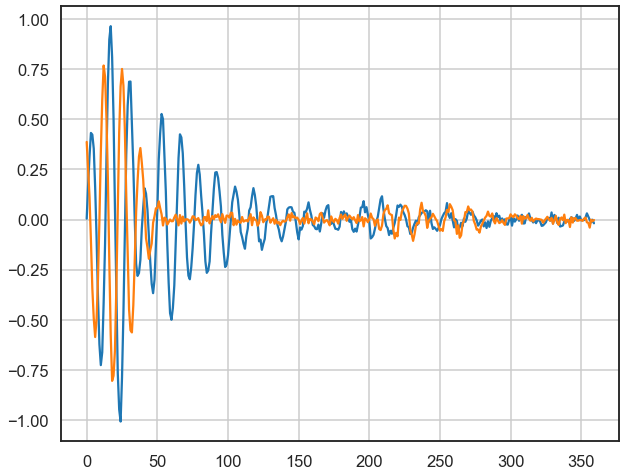

In [66]:
plt.figure(figsize=(10,8))
plt.plot(verasonics_data[0,:])
plt.plot(X_sample_n_crop[42,0,:])
plt.grid()
plt.show()

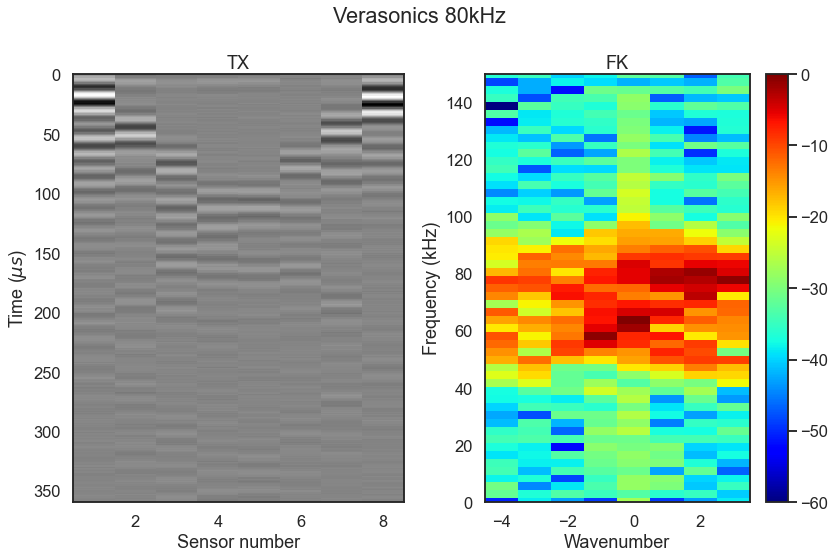

In [67]:
tx_fk_plot(verasonics_data.T, dt, make_dtheta(1), title='Verasonics 80kHz')

In [68]:
X_sample_n_crop.shape

(3341, 8, 360)

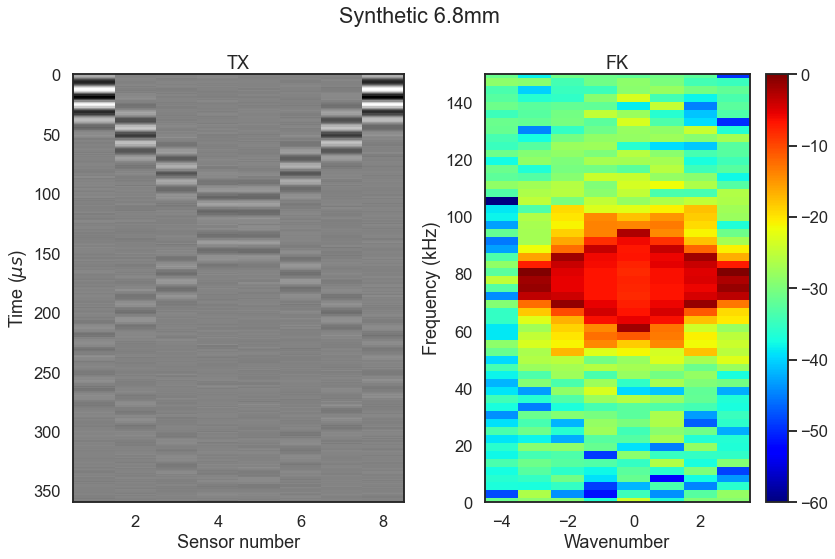

In [69]:
tx_fk_plot(X_sample_n_crop[42,:,:].T, dt, make_dtheta(1), title='Synthetic 6.8mm', log=True)

# Conventinal Thickness Estimation

In [70]:
steel = make_lamb_curves()


Calculating symmetric modes..

0/100 - 0.0 kHz × mm
1/100 - 101.0 kHz × mm
2/100 - 202.0 kHz × mm
3/100 - 303.0 kHz × mm
4/100 - 404.0 kHz × mm
5/100 - 505.1 kHz × mm
6/100 - 606.1 kHz × mm
7/100 - 707.1 kHz × mm
8/100 - 808.1 kHz × mm
9/100 - 909.1 kHz × mm
10/100 - 1010.1 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = omega/vp
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:229: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt((omega/self.c_L)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:230: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt((omega/self.c_S)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:256: RuntimeWarning: invalid value encountered in cdouble_scalars
  symmetric = (np.tan(q*self.h)/q
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:257: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (4*(k**2)*p*np.tan(p*self.h))/(q**2 - k**2)**2)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.p

11/100 - 1111.1 kHz × mm
12/100 - 1212.1 kHz × mm
13/100 - 1313.1 kHz × mm
14/100 - 1414.1 kHz × mm
15/100 - 1515.2 kHz × mm
16/100 - 1616.2 kHz × mm
17/100 - 1717.2 kHz × mm
18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm
20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49/100 - 4949.5 kHz × mm
50/100 - 5050.5 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  antisymmetric = (q * np.tan(q*self.h)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in multiply
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))


9/100 - 909.1 kHz × mm
10/100 - 1010.1 kHz × mm
11/100 - 1111.1 kHz × mm
12/100 - 1212.1 kHz × mm
13/100 - 1313.1 kHz × mm
14/100 - 1414.1 kHz × mm
15/100 - 1515.2 kHz × mm
16/100 - 1616.2 kHz × mm
17/100 - 1717.2 kHz × mm
18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm
20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49

In [71]:
help(steel)

Help on Lamb in module comsolml.lamb.lamb object:

class Lamb(builtins.object)
 |  Lamb(thickness, nmodes_sym, nmodes_antisym, fd_max, vp_max, c_L, c_S, c_R=None, fd_points=100, vp_step=100, material='')
 |  
 |  A class used to calculate and plot Lamb wave dispersion curves 
 |  for traction-free, homogeneous and isotropic plates. It also allows 
 |  to generate an animation of the displacement vector field.
 |  
 |  Methods
 |  -------
 |  plot_phase_velocity(modes, cutoff_frequencies, material_velocities,
 |                      save_img, sym_style, antisym_style):
 |      Plot phase velocity as a function of frequency × thickness.
 |  plot_group_velocity(modes, cutoff_frequencies, save_img, sym_style,
 |                      antisym_style):
 |      Plot group velocity as a function of frequency × thickness.
 |  plot_wave_number(modes, save_img, sym_style, antisym_style):
 |      Plot wavenumber as a function of frequency × thickness.
 |  plot_wave_structure(mode, nrows, ncols, fd, 

In [72]:
ds = np.arange(5, 9.0, 0.05)

In [73]:
sns.set_context("paper")

In [74]:
labels[(labels['Thickness std'] == 0)].head(20)

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
0,model_s101_t032_d000_p000,6.4,101,0.0,0.0,351.267366,55.653407,6.4,6.4,6.4,6.4,0.0,0.0,1.0,0
42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.8,6.8,0.0,0.0,1.0,0
84,model_s101_t036_d000_p000,7.2,101,0.0,0.0,351.267366,55.653407,7.2,7.2,7.2,7.2,0.0,0.0,1.0,0
126,model_s101_t038_d000_p000,7.6,101,0.0,0.0,351.267366,55.653407,7.6,7.6,7.6,7.6,0.0,0.0,1.0,0
168,model_s101_t040_d000_p000,8.0,101,0.0,0.0,351.267366,55.653407,8.0,8.0,8.0,8.0,0.0,0.0,1.0,0
210,model_s102_t032_d000_p000,6.4,102,0.0,0.0,379.358756,64.078952,6.4,6.4,6.4,6.4,0.0,0.0,1.0,0
250,model_s102_t034_d000_p000,6.8,102,0.0,0.0,379.358756,64.078952,6.8,6.8,6.8,6.8,0.0,0.0,1.0,0
292,model_s102_t036_d000_p000,7.2,102,0.0,0.0,379.358756,64.078952,7.2,7.2,7.2,7.2,0.0,0.0,1.0,0
334,model_s102_t038_d000_p000,7.6,102,0.0,0.0,379.358756,64.078952,7.6,7.6,7.6,7.6,0.0,0.0,1.0,0
376,model_s102_t040_d000_p000,8.0,102,0.0,0.0,379.358756,64.078952,8.0,8.0,8.0,8.0,0.0,0.0,1.0,0


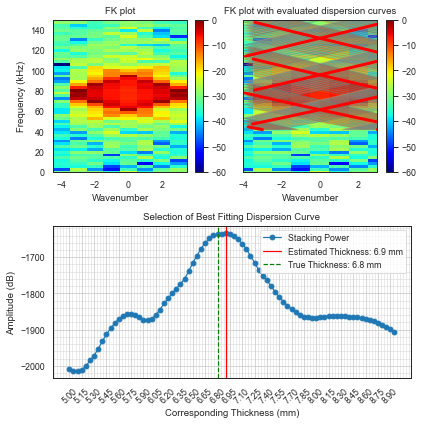

6.9

In [75]:
fk_c, k_array, f_array = make_fk(X_sample_n_crop[42,:,:].T, dt, make_dtheta(1))
#fk = np.abs(fk_c)
fk = 20*np.log10(np.abs(fk_c)/np.max(np.abs(fk_c)))
FK_thickness_estimation(fk, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 150e3, angular=True, circumference=circ, d_true=6.8, db=True)

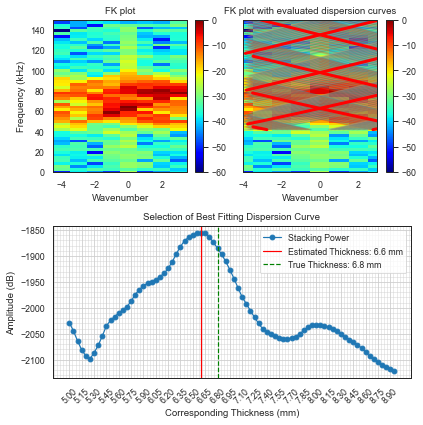

6.6

In [76]:
fk_c, k_array, f_array = make_fk(verasonics_data.T, dt, make_dtheta(1))
#fk = np.abs(fk_c)
fk = 20*np.log10(np.abs(fk_c)/np.max(np.abs(fk_c)))
FK_thickness_estimation(fk, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 150e3, angular=True, circumference=circ, d_true=6.8, db=True, circ_correction=True)

In [77]:
len(verasonics_data), X_sample_n_crop[42,:,:].shape[0]

(8, 8)

In [78]:
spect_v = np.zeros(len(verasonics_data))

In [79]:
spect_v.shape

(8,)

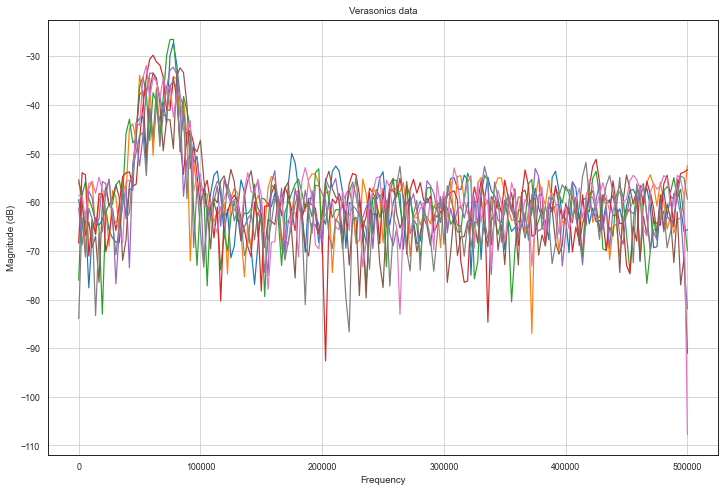

In [80]:
spect_v = list()
freqs_v = list()
segments_v = list()
plt.figure(figsize=(12,8))
plt.title('Verasonics data')
plt.grid()
for i in range(len(verasonics_data)):
    
    spect_v_temp, freqs_v_temp, line = plt.magnitude_spectrum(verasonics_data[i], Fs=1e6, scale='dB')
    spect_v.append(spect_v_temp)
    freqs_v.append(freqs_v_temp)
    segments_v.append(np.column_stack([freqs_v_temp, 20*np.log10(spect_v_temp)]))


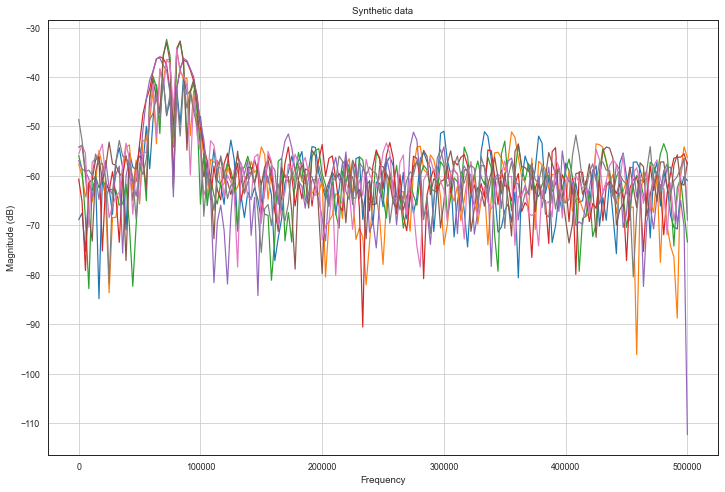

In [81]:
spect_s = list()
freqs_s = list()
segments_s = list()
plt.figure(figsize=(12,8))
plt.title('Synthetic data')
plt.grid()
for i in range(X_sample_n_crop[42,:,:].shape[0]):
    spect_s_temp, freqs_s_temp, line = plt.magnitude_spectrum(X_sample_n_crop[42,i,:], Fs=1e6, scale='dB')
    spect_s.append(spect_s_temp)
    freqs_s.append(freqs_s_temp)
    segments_s.append(np.column_stack([freqs_s_temp, 20*np.log10(spect_s_temp)]))

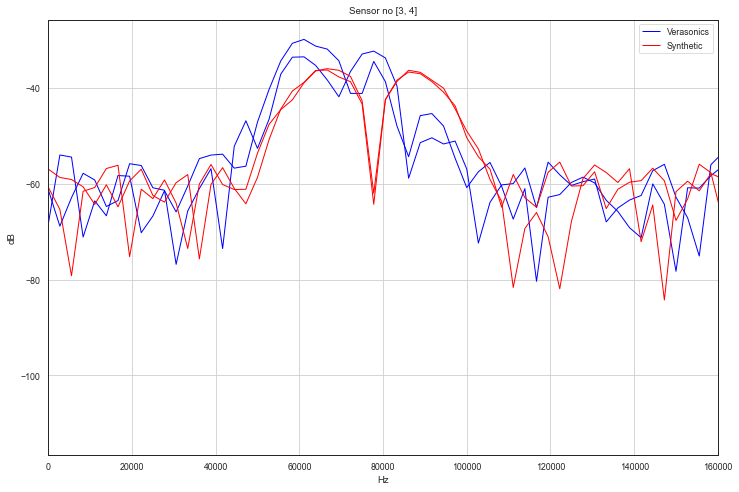

In [82]:

s = 3
indeces = [0+s, 7-s]
line_collection_v = LineCollection(list(map(lambda x: segments_v[x], indeces)), colors='blue', linewidths=1, label='Verasonics')
line_collection_s = LineCollection(list(map(lambda x: segments_s[x], indeces)), colors='red', linewidths=1, label='Synthetic')
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(line_collection_v)
ax.add_collection(line_collection_s)
ax.autoscale()
ax.set_xlim(0, 160e3)
ax.set_xlabel('Hz')
ax.set_ylabel('dB')
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)} dB"))
plt.legend()
plt.title(f'Sensor no {indeces}')
plt.grid()
plt.show()

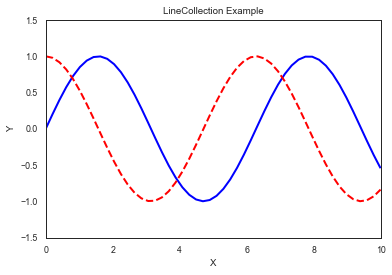

In [83]:
# Create some sample data
x = np.linspace(0, 10, 50)
y1 = np.sin(x)
y2 = np.cos(x)

# Create line segments from data
segments1 = np.column_stack([x, y1])
segments2 = np.column_stack([x, y2])

# Create a LineCollection from the line segments
segments = [segments1, segments2]
line_collection = LineCollection(segments, colors=['blue', 'red'], linestyles=['solid', 'dashed'], linewidths=2)

# Create a figure and axis
fig, ax = plt.subplots()

# Add the LineCollection to the axis
ax.add_collection(line_collection)

# Set plot limits and labels
ax.set_xlim(0, 10)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('LineCollection Example')

# Show the plot
plt.show()

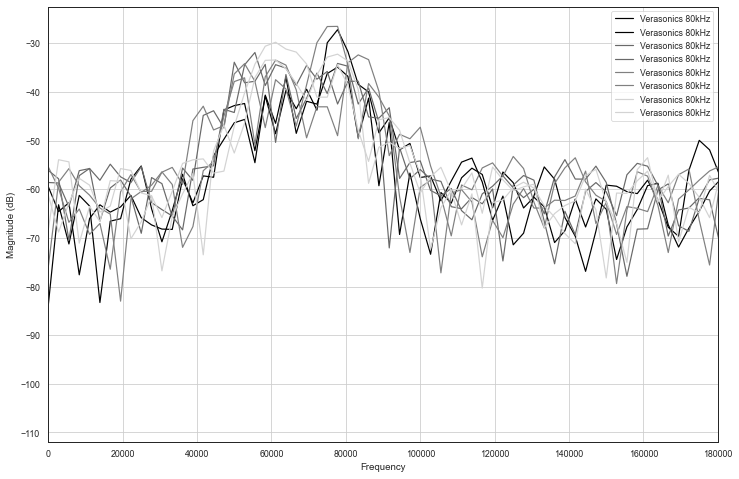

In [84]:
plt.figure(figsize=(12,8))
plt.magnitude_spectrum(verasonics_data[0], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='black', ls='-')
plt.magnitude_spectrum(verasonics_data[7], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='black', ls='-')
plt.magnitude_spectrum(verasonics_data[1], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='dimgray', ls='-')
plt.magnitude_spectrum(verasonics_data[6], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='dimgray', ls='-')
plt.magnitude_spectrum(verasonics_data[2], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='gray', ls='-')
plt.magnitude_spectrum(verasonics_data[5], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='gray', ls='-')
plt.magnitude_spectrum(verasonics_data[3], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='lightgray', ls='-')
plt.magnitude_spectrum(verasonics_data[4], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='lightgray', ls='-')
#plt.magnitude_spectrum(X_sample_n_crop[168,1,:], Fs=1e6, scale='dB', label='Simulated')
plt.xlim(0, 180e3)
plt.grid()
plt.legend()
plt.show()

# Machine Learning

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n_crop, X_sample_c_crop, test_size=0.2, random_state=42)

In [86]:
def make_fk_samples(X, dt, dx, fk_minfreq=40e3, fk_maxfreq=120e3, returncomplex=False, returndb=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)#/np.max(np.abs(fk_temp))
        if returndb:
          fk_temp_amp = 20*np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= fk_minfreq) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [87]:
X_sample_n_crop = np.expand_dims(X_sample_n_crop, 1)
X_sample_c_crop = np.expand_dims(X_sample_c_crop, 1)

In [88]:
dt

1e-06

In [89]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n_crop, dt, make_dx(1), returndb=False)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c_crop, dt, make_dx(1), returndb=False)

(3341, 1, 2, 360, 8)


(3341, 1, 2, 360, 8)


In [90]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [91]:
X_sample_n_fk.shape, X_sample_c_fk.shape

((3341, 1, 29, 8), (3341, 1, 29, 8))

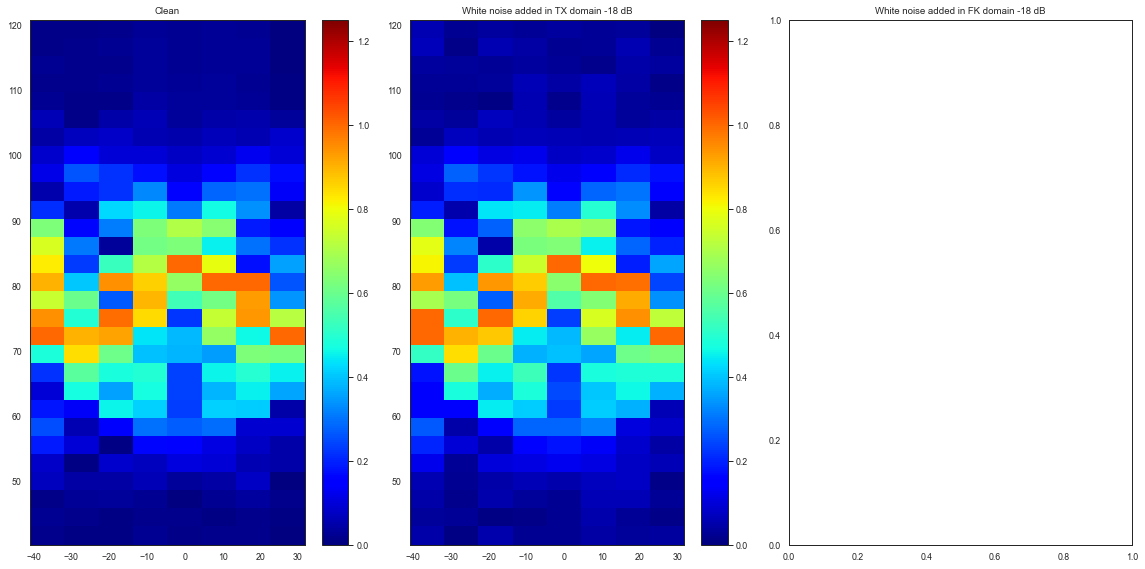

In [92]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title('Clean')
plt.subplot(1,3,2)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in TX domain {noisedb} dB')
plt.subplot(1,3,3)
#plt.pcolormesh(x_array, f_array/1e3, X_sample_c_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
#plt.colorbar()
plt.title(f'White noise added in FK domain {noisedb} dB')
plt.tight_layout()
plt.show()

In [93]:
x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [94]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [95]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((2672, 232), (669, 232), (2672, 232), (669, 232))

In [96]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

## Direct regression in FK

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


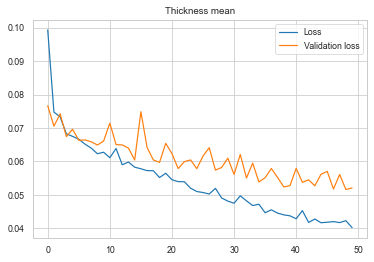

21/21 [==============================] - 0s 1ms/step - loss: 0.0521
loss: 0.05206712707877159
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


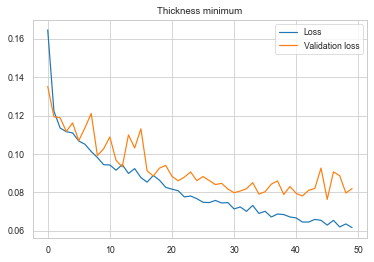

21/21 [==============================] - 0s 2ms/step - loss: 0.0820
loss: 0.08197799324989319
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


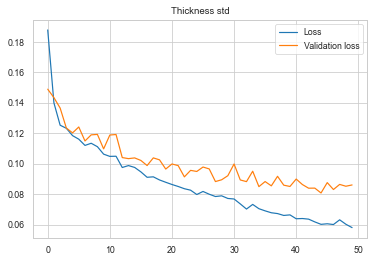

21/21 [==============================] - 0s 2ms/step - loss: 0.0860
loss: 0.08602871000766754
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


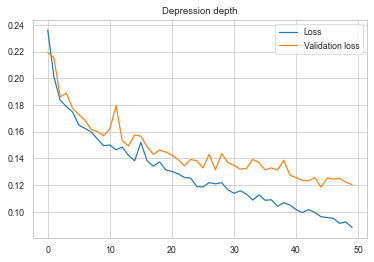

21/21 [==============================] - 0s 3ms/step - loss: 0.1205
loss: 0.12049386650323868
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


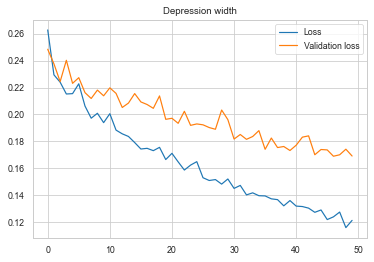

21/21 [==============================] - 0s 3ms/step - loss: 0.1691
loss: 0.16912512481212616
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


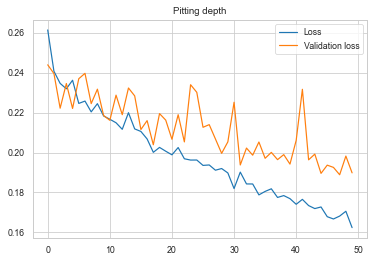

21/21 [==============================] - 0s 2ms/step - loss: 0.1898
loss: 0.1898331642150879


In [97]:
df_loss, df_test, df_predict, direct_regression_models_fk, min_max_scalers = do_regression(X_sample_n_fk, labels, attributes)

In [98]:
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

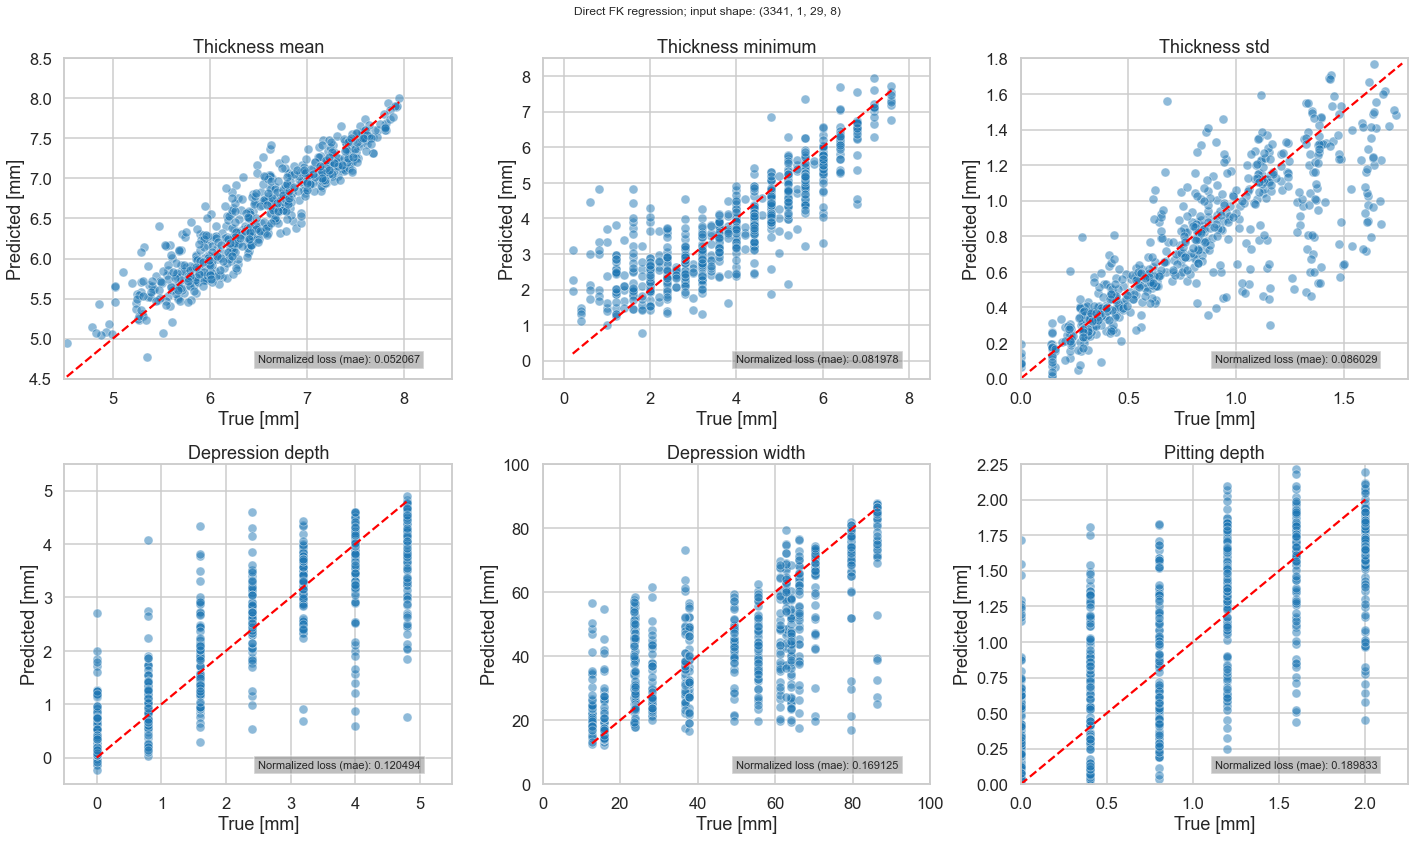

In [99]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct FK regression; input shape: '+ str(X_sample_n_fk.shape))

In [100]:
#stop

## Autoencoder in FK

Epoch 1/100


11/11 [==============================] - 1s 20ms/step - loss: 0.1222 - val_loss: 0.1014
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0849 - val_loss: 0.0648
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0522 - val_loss: 0.0390
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0325 - val_loss: 0.0262
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0232 - val_loss: 0.0206
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.0186
Epoch 7/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 8/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0177 - val_loss: 0.0173
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0171 - val_loss: 0.0165
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 11/100
11/11 

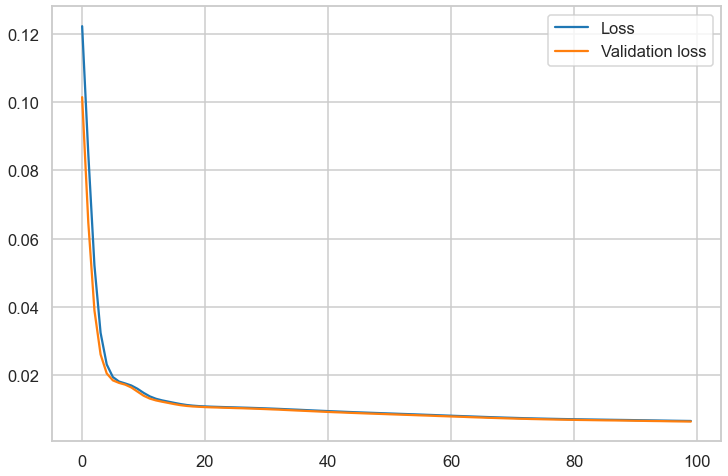

In [101]:
autoencoder_fk, encoder_fk = make_autoencoder(input_dim=x_train_flat_fk.shape[1], encoding_dim=16, activation='relu') #was 24
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [102]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

21/21 [==============================] - 0s 2ms/step


21/21 [==============================] - 0s 2ms/step


In [103]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [104]:
decoded_shaped_fk.shape, x_test_fk.shape

((669, 1, 29, 8), (669, 1, 29, 8))

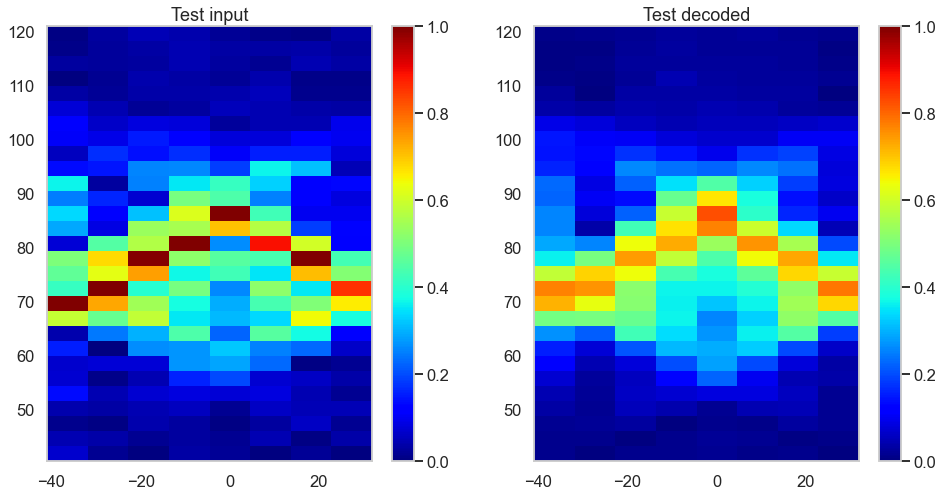

In [105]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

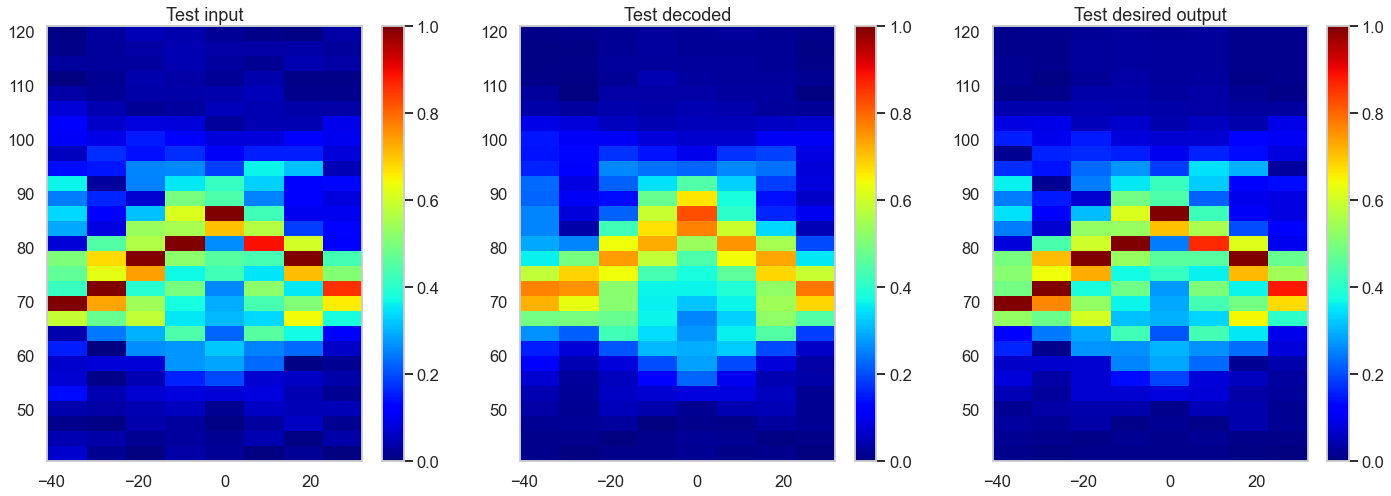

In [106]:
#sampleno = 3
for sampleno in range(0,1):
  plt.figure(figsize=(24,8))

  plt.subplot(1, 3, 1)
  plt.pcolormesh(x_array, f_array/1e3, x_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test input')

  plt.subplot(1, 3, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test decoded')

  plt.subplot(1, 3, 3)
  plt.pcolormesh(x_array, f_array/1e3, y_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test desired output')


  #plt.savefig('./images/simulations_autoencoder_' + str(sampleno).zfill(2) + '.png')
  plt.show()

In [107]:
X_sample_flat_fk = X_sample_n_fk.reshape((len(X_sample_n_fk), np.prod(X_sample_n_fk.shape[1:])))
X_sample_flat_fk.shape

(3341, 232)

In [108]:
encoded_all_fk = encoder_fk.predict(X_sample_flat_fk)

105/105 [==============================] - 0s 2ms/step


Thickness mean
Layer added; size: 4
Layer added; size: 2


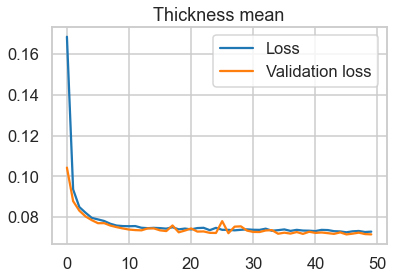

21/21 [==============================] - 0s 525us/step - loss: 0.0715
loss: 0.07149777561426163
Thickness minimum
Layer added; size: 4
Layer added; size: 2


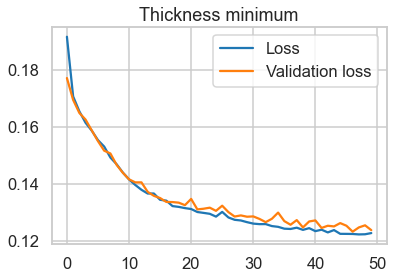

21/21 [==============================] - 0s 2ms/step - loss: 0.1237
loss: 0.12365715950727463
Thickness std
Layer added; size: 4
Layer added; size: 2


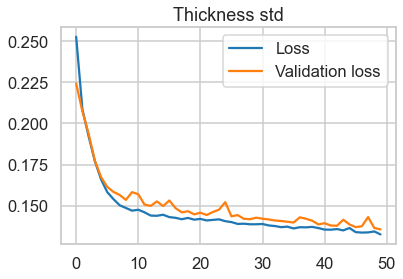

21/21 [==============================] - 0s 1ms/step - loss: 0.1356
loss: 0.13562315702438354
Depression depth
Layer added; size: 4
Layer added; size: 2


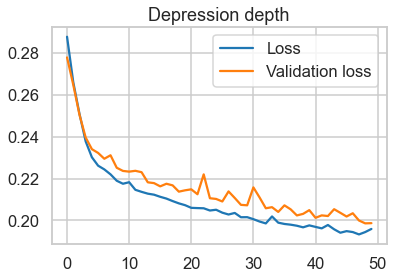

21/21 [==============================] - 0s 2ms/step - loss: 0.1987
loss: 0.19866792857646942
Depression width
Layer added; size: 4
Layer added; size: 2


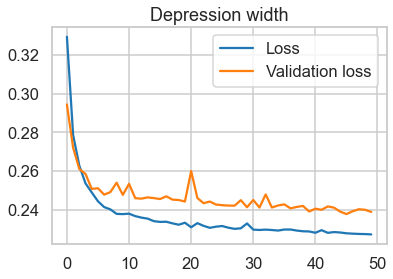

21/21 [==============================] - 0s 1ms/step - loss: 0.2387
loss: 0.23874540627002716
Pitting depth
Layer added; size: 4
Layer added; size: 2


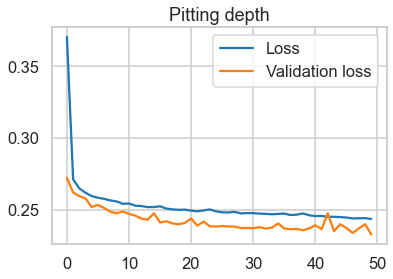

21/21 [==============================] - 0s 1ms/step - loss: 0.2327
loss: 0.2326659858226776


In [109]:
df_loss, df_test, df_predict, autoencoder_regression_models_fk, min_max_scalers = do_regression(encoded_all_fk, labels, attributes)

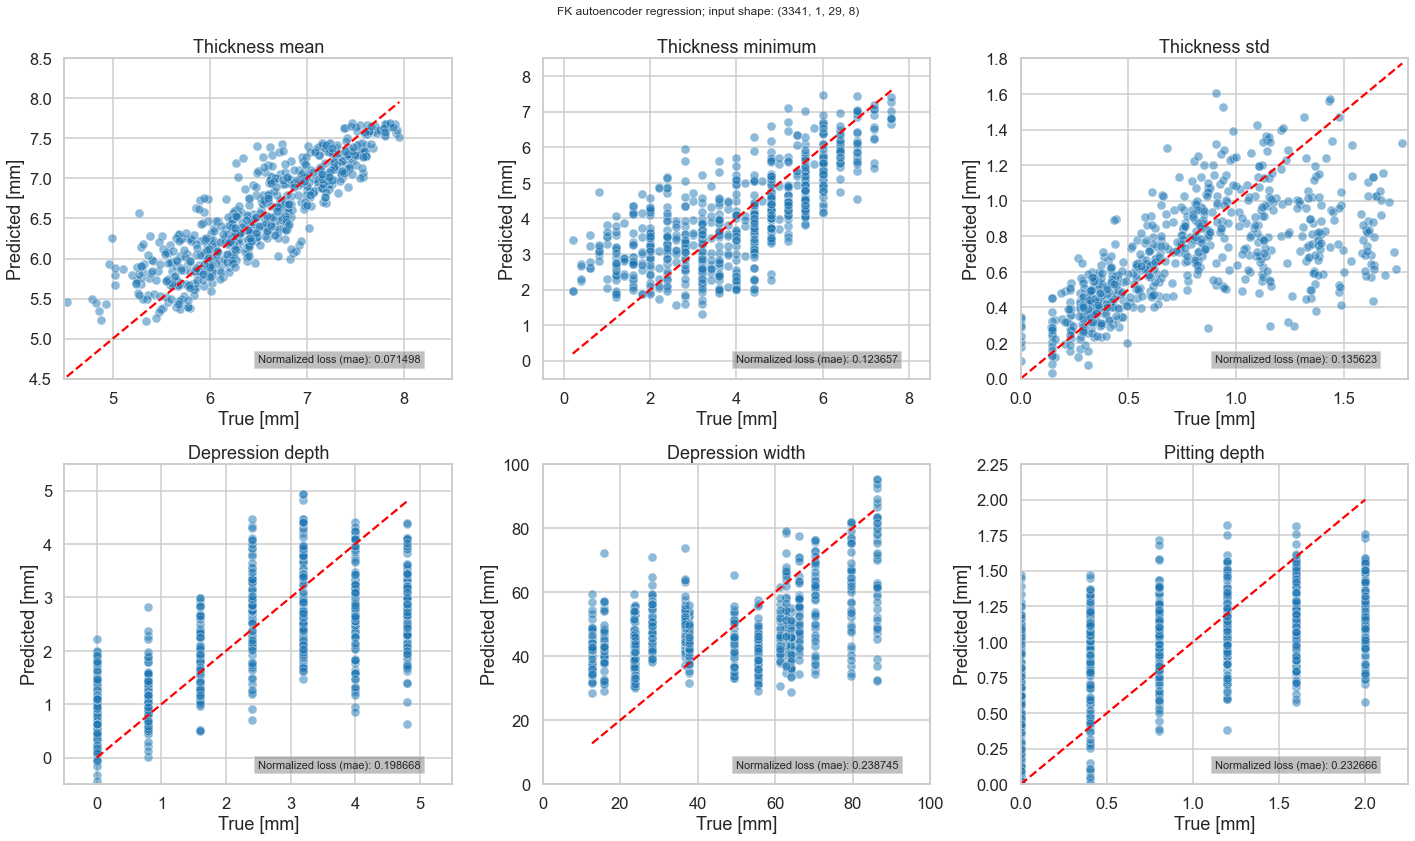

In [110]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='FK autoencoder regression; input shape: '+ str(X_sample_n_fk.shape))

In [111]:
def decode_sample(autoencoder, sample):
  sample_flat = sample.reshape(np.prod(sample.shape))
  sample_flat = np.expand_dims(sample_flat, axis=0)
  decoded_sample = autoencoder.predict(sample_flat)
  decoded_sample_shaped = decoded_sample.reshape(sample.shape)
  return decoded_sample_shaped

In [112]:
verasonics_data_expanded = np.expand_dims(verasonics_data, [0, 1])

In [113]:
verasonics_data_expanded.shape

(1, 1, 8, 360)

In [114]:
verasonics_fk, verasonics_x_array, verasonics_f_array = make_fk_samples(verasonics_data_expanded, dt, make_dx(1), returndb=False)

(1, 1, 2, 360, 8)


In [115]:
verasonics_fk.shape

(1, 1, 2, 29, 8)

In [116]:
verasonics_fk = verasonics_fk[:,:,0,:,:]

In [117]:
verasonics_fk.shape

(1, 1, 29, 8)

In [118]:
decoded_measurement_fk = decode_sample(autoencoder_fk, verasonics_fk)

1/1 [==============================] - 0s 22ms/step


In [119]:
decoded_measurement_fk.shape

(1, 1, 29, 8)

1/1 [==============================] - 0s 24ms/step


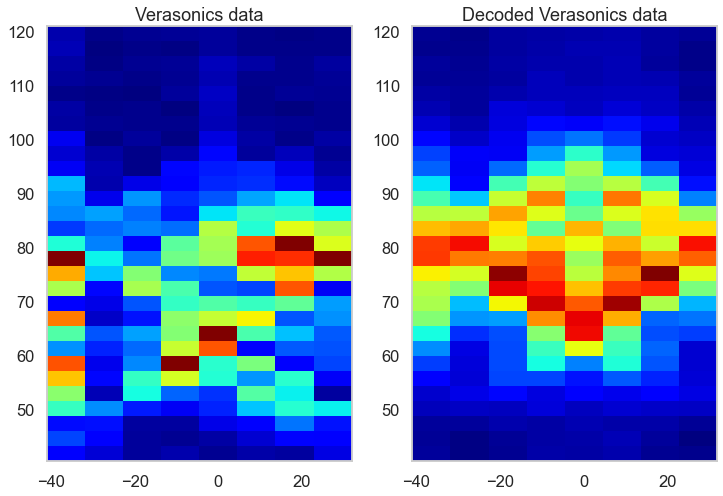

In [120]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(verasonics_x_array, verasonics_f_array/1e3, verasonics_fk[0,0,:,:], cmap='jet')
plt.title('Verasonics data')
plt.subplot(1,2,2)
plt.pcolormesh(verasonics_x_array, verasonics_f_array/1e3, decode_sample(autoencoder_fk, verasonics_fk)[0,0,:,:], cmap='jet')
plt.title('Decoded Verasonics data')
plt.show()

### Conventional thickness estimation on decoded verasonics dataset

1/1 [==============================] - 0s 25ms/step


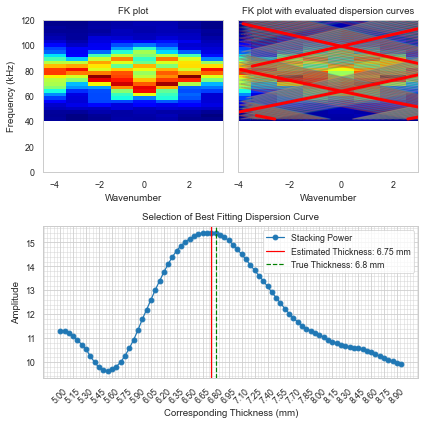

6.75

In [121]:
sns.set_context('paper')
FK_thickness_estimation(decode_sample(autoencoder_fk, verasonics_fk)[0,0,:,:], k_array, verasonics_f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, d_true=6.8, db=False, circ_correction=True)

### Regression on encodings

In [122]:
measurements_flat_fk = verasonics_fk.reshape((len(verasonics_fk), np.prod(verasonics_fk.shape[1:])))

In [123]:
encoded_measurements_fk = encoder_fk.predict(measurements_flat_fk)

1/1 [==============================] - 0s 22ms/step


In [124]:
real_prediction = {}
for i, attribute in enumerate(attributes):
    real_prediction_norm = autoencoder_regression_models_fk[attribute](encoded_measurements_fk)
    real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)

In [125]:
real_prediction

{'Thickness mean': array([[6.92037954]]),
 'Thickness minimum': array([[5.64991959]]),
 'Thickness std': array([[0.54656966]]),
 'Depression depth': array([[1.77560577]]),
 'Depression width': array([[48.5148855]]),
 'Pitting depth': array([[0.73037851]])}